<a href="https://colab.research.google.com/github/DivyaMeenaSundaram/Deep_Learning_Lab/blob/main/Agri_YOLOE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics opencv-python matplotlib torch torchvision

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch.nn.functional as F

In [ ]:
model = YOLO("yoloe-26s-seg.pt")   # change path if needed

In [ ]:
backbone = model.model.model[-2]
backbone.eval()

C3k2(
  (cv1): Conv(
    (conv): Conv2d(768, 512, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(768, 512, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (cv1): Conv(
          (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
      (1): PSABlock(
        (attn): Attention(
          (qkv): Conv(
            (conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
            (act): Identity()
          )
          (proj): Conv(
            (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
            (act): Identity()
          )
          (pe): Conv(
            (conv): Conv2d(256, 256, kernel_si

In [ ]:
prompt_paths = [
    "ld1.jpg",
    "ld2.jpg",
]

test_path = "p1.png"

In [ ]:
def preprocess(img, size=512):
    img = cv2.resize(img, (size, size))
    tensor = torch.tensor(img).permute(2,0,1).float()/255.0
    return tensor.unsqueeze(0)

In [ ]:
test_bgr = cv2.imread(test_path)
test_rgb = cv2.cvtColor(test_bgr, cv2.COLOR_BGR2RGB)

test_tensor = preprocess(test_rgb, 512)

In [ ]:
with torch.no_grad():
    x = test_tensor
    y = [] # List to store outputs of previous layers
    # Iterate through layers up to, but not including, the backbone (model.model.model[-2])
    # The loop processes layers 0 to len(model.model.model) - 3.
    for i, m in enumerate(model.model.model[:-2]):
        # Determine the input for the current module 'm'
        if hasattr(m, 'f') and m.f != -1:
            if isinstance(m.f, int):
                # If m.f is an int, the input is from a specific previous layer's output stored in 'y'
                current_input = y[m.f]
            elif isinstance(m.f, list):
                # If m.f is a list, the input is a list of tensors, potentially including current 'x' and other 'y' elements
                current_input = [x if j == -1 else y[j] for j in m.f]
            else:
                raise ValueError(f"Unsupported 'from' type: {type(m.f)}")
        else:
            # If m.f is -1 (or not present), the input is the output of the previous layer (current 'x')
            current_input = x

        # Perform the forward pass for the current module
        x = m(current_input)

        # Store the output 'x' in the 'y' list for potential skip connections
        y.append(x)

    # After the loop, x holds the output of model.model.model[-3], which is the input for the backbone
    feat_test = backbone(x)
    feat_test = F.normalize(feat_test, dim=1)

In [ ]:
prompt_vectors = []

for path in prompt_paths:

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    tensor = preprocess(img, 256)

    with torch.no_grad():
        x = tensor
        y = [] # List to store outputs of previous layers
        # Iterate through layers up to, but not including, the backbone (model.model.model[-2])
        # The loop processes layers 0 to len(model.model.model) - 3.
        for i, m in enumerate(model.model.model[:-2]):
            # Determine the input for the current module 'm'
            if hasattr(m, 'f') and m.f != -1:
                if isinstance(m.f, int):
                    # If m.f is an int, the input is from a specific previous layer's output stored in 'y'
                    current_input = y[m.f]
                elif isinstance(m.f, list):
                    # If m.f is a list, the input is a list of tensors, potentially including current 'x' and other 'y' elements
                    current_input = [x if j == -1 else y[j] for j in m.f]
                else:
                    raise ValueError(f"Unsupported 'from' type: {type(m.f)}")
            else:
                # If m.f is -1 (or not present), the input is the output of the previous layer (current 'x')
                current_input = x

            # Perform the forward pass for the current module
            x = m(current_input)

            # Store the output 'x' in the 'y' list for potential skip connections
            y.append(x)

        # After the loop, x holds the output of model.model.model[-3], which is the input for the backbone
        feat = backbone(x)
        feat = F.normalize(feat, dim=1)

        # attention pooling
        # Get the mean across the channel dimension and keep dimensions (B, 1, H, W)
        attention_scores = feat.mean(dim=1, keepdim=True)

        # Flatten spatial dimensions (H*W) for softmax (B, 1, H*W)
        B, C, H, W = attention_scores.shape
        attention_scores_flat = attention_scores.view(B, C, H * W)

        # Apply softmax over the flattened spatial dimension
        weights_flat = F.softmax(attention_scores_flat, dim=-1)

        # Reshape weights back to original spatial dimensions (B, 1, H, W)
        weights = weights_flat.view(B, C, H, W)

        vec = (feat * weights).sum(dim=(2,3), keepdim=True)

        prompt_vectors.append(vec)

# average multiple prompts
prompt_vec = torch.mean(torch.stack(prompt_vectors), dim=0)

In [ ]:
sim_map = (feat_test * prompt_vec).sum(dim=1).squeeze().cpu().numpy()

sim_map = cv2.resize(sim_map, (test_rgb.shape[1], test_rgb.shape[0]))

# normalize
sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())

# smooth
sim_map = cv2.GaussianBlur(sim_map, (15,15), 0)

In [ ]:
threshold = np.percentile(sim_map, 85)

mask = (sim_map > threshold).astype(np.uint8) * 255

kernel = np.ones((7,7), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

In [ ]:
yolo_results = model.predict(test_path, conf=0.25)[0]


image 1/1 /content/p1.png: 384x640 (no detections), 1374.9ms
Speed: 11.7ms preprocess, 1374.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
boxes = yolo_results.boxes.xyxy.cpu().numpy() if yolo_results.boxes is not None else []

In [ ]:
refined_boxes = []

for box in boxes:

    x1,y1,x2,y2 = map(int, box)

    region = mask[y1:y2, x1:x2]

    if region.size == 0:
        continue

    score = np.mean(region)/255

    if score > 0.2:   # similarity threshold
        refined_boxes.append((x1,y1,x2,y2))

In [ ]:
leaf_area = mask.size
disease_area = np.sum(mask > 0)

severity = (disease_area / leaf_area) * 100

print(f"Disease Severity: {severity:.2f}%")

Disease Severity: 14.96%


In [ ]:
if yolo_results.masks is not None:
    leaf_mask = yolo_results.masks.data[0].cpu().numpy()
    leaf_area = np.sum(leaf_mask > 0)
    disease_area = np.sum(mask > 0)
    severity = (disease_area / leaf_area) * 100

In [ ]:
output = test_bgr.copy()

for (x1,y1,x2,y2) in refined_boxes:
    cv2.rectangle(output, (x1,y1), (x2,y2), (0,255,0), 2)

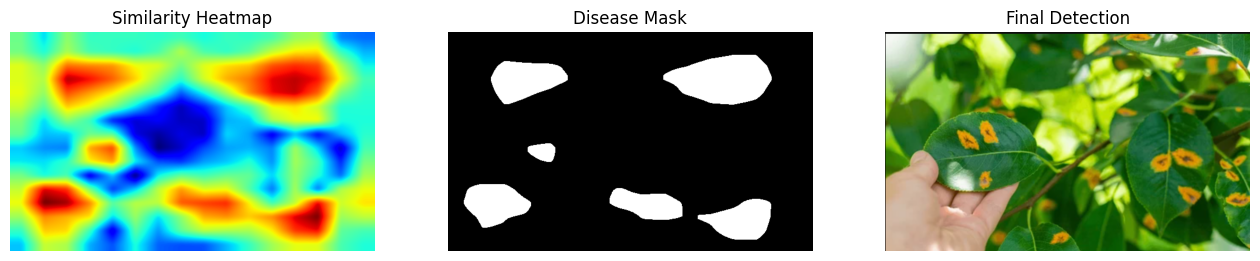

In [ ]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.title("Similarity Heatmap")
plt.imshow(sim_map, cmap='jet')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Disease Mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Final Detection")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

In [ ]:
cv2.imwrite("final_detection.jpg", output)
cv2.imwrite("disease_mask.jpg", mask)

True